In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import ncx2
from mpl_toolkits.mplot3d import Axes3D 
from tqdm import tqdm
from scipy.stats import beta  # For generating exact solution if available
from scipy.special import betainc, gamma
from scipy.integrate import quad

In [2]:
class StochasticProcess:
    def __init__(self, params, T, Nx, Nt, init_state = None):
        self.params = params
        self.T = T
        self.Nx = Nx # Number of trajectories
        self.Nt = Nt # Number of discretization steps
        self.init_state = init_state

        #Wiener Process by default
        self.bxt = lambda x: 0
        self.sigmaxt = lambda x: 1
        self.bxt_x = lambda x: 0
        self.bxt_xx = lambda x: 0
        self.sigmaxt_x = lambda x: 0
        self.sigmaxt_xx = lambda x: 0

    def DefaultInitState(self):
        return np.zeros(self.Nx)

    def SampleFromDensity(self, x0, t, t0):
        result = np.zeros(self.Nx)
        for k in range(0, self.Nx):
            result[k] = x0[k] + np.random.normal(0, 1) * np.sqrt(t - t0)
        return result

    def PathGenerator(self):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = self.SampleFromDensity(x_data[i - 1], t_data[i], t_data[i - 1])
        return t_data, x_data

    def ExactSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + dwt[i - 1]
        return t_data, x_data

    def EulerSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt[i - 1]
        return t_data, x_data

    def Milstein1Solution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt[i - 1] + \
                        1/2 * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1]) * (dwt[i - 1]**2 - dt)
        return t_data, x_data

    def Milstein2Solution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + (self.bxt(x_data[i - 1]) - 1/2 * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1])) * dt +\
                        self.sigmaxt(x_data[i - 1]) * dwt[i - 1] + 1/2 * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1]) * dwt[i - 1]**2 +\
                        (1/2 * self.bxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1]) + 1/2 * self.bxt_x(x_data[i - 1]) * self.sigmaxt(x_data[i - 1]) +\
                        1/4 * self.sigmaxt(x_data[i - 1])**2 * self.sigmaxt_xx(x_data[i - 1])) * dt * dwt[i - 1] +\
                        (1/2 * self.bxt(x_data[i - 1]) * self.bxt_x(x_data[i - 1]) + 1/4 * self.bxt_xx(x_data[i - 1]) * self.sigmaxt(x_data[i - 1])**2) * dt**2
        return t_data, x_data

    def PredictorCorrectorSolution(self, dwt, eta = 1/2, alpha = 1/2):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            yw = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt[i - 1]
            bwim1 = self.bxt(x_data[i - 1]) - eta * self.sigmaxt(x_data[i - 1]) * self.sigmaxt_x(x_data[i - 1])
            bwi = self.bxt(yw) - eta * self.sigmaxt(yw) * self.sigmaxt_x(yw)
            x_data[i] = x_data[i - 1] + alpha * bwi * dt + (1 - alpha) * bwim1 * dt +\
                        eta * self.sigmaxt(yw) * dwt[i - 1] + (1 - eta) * self.sigmaxt(x_data[i - 1]) * dwt[i - 1]
        return t_data, x_data


class OUprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta, mu, sigma]
        self.bxt = lambda x: self.params[0] * (self.params[1] - x)
        self.sigmaxt = lambda x: self.params[2]
        self.bxt_x = lambda x: -self.params[0]

    def DefaultInitState(self):
        return self.params[1] * np.ones(self.Nx)

    def StationaryState(self):
        theta = self.params[0]
        mu = self.params[1]
        sigma = self.params[2]

        result = np.zeros(self.Nx)

        for j in range(0, self.Nx):
            m = mu
            v = sigma**2 / (2 * theta)
            result[j] = np.random.normal(m, np.sqrt(v))
        return result

    def SampleFromDensity(self, x0, t, t0):
        theta = self.params[0]
        mu = self.params[1]
        sigma = self.params[2]

        result = np.zeros(self.Nx)

        for j in range(0, self.Nx):
            m = mu + (x0[j] - mu) * np.exp(-theta * (t - t0))
            v = sigma**2 / (2 * theta) * (1 - np.exp(-2 * theta * (t - t0)))
            result[j] = np.random.normal(m, np.sqrt(v))
        return result

    def ExactSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        theta = self.params[0]
        mu = self.params[1]
        sigma = self.params[2]

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        Ito_integral_sum = np.zeros(self.Nx)
        Determinated_part = mu + (x_data[0] - mu) * np.exp(-theta * t_data)
        for i in range(1, self.Nt + 1):
            Ito_integral_sum += sigma * np.exp(theta * t_data[i - 1]) * dwt[i - 1]
            x_data[i] = Determinated_part[i] + Ito_integral_sum * np.exp(-theta * t_data[i])
        return t_data, x_data


class CIRprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta1, theta2, theta3]
        self.bxt = lambda x: self.params[0] - self.params[1] * x
        self.sigmaxt = lambda x: self.params[2] * np.sqrt(np.maximum(x, 0))
        self.bxt_x = lambda x: - self.params[1]
        self.sigmaxt_x = lambda x: self.params[2] * 1 / (2 * np.sqrt(np.maximum(x, 0)))
        self.sigmaxt_xx = lambda x: -self.params[2] * 1 / (4 * np.maximum(x, 0)**(1/4))

    def DefaultInitState(self):
        return self.params[0] / self.params[1] * np.ones(self.Nx)

    def StationaryState(self):
        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        k = theta2
        theta = theta1 / theta2
        sigma = theta3

        result = np.zeros(self.Nx)

        for j in range(0, self.Nx):
            c = 2 * k / (sigma**2)
            u = 0
            q = 2 * k * theta / sigma**2 - 1
            result[j] = ncx2.rvs(2 * q + 2, 2 * u) / (2 * c)
        return result

    def SampleFromDensity(self, x0, t, t0):
        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        k = theta2
        theta = theta1 / theta2
        sigma = theta3

        result = np.zeros(self.Nx)

        for j in range(0, self.Nx):
            c = 2 * k / (sigma**2 * (1 - np.exp(-k * (t - t0))))
            u = c * x0[j] * np.exp(-k * (t - t0))
            #v = c * x
            q = 2 * k * theta / sigma**2 - 1
            result[j] = ncx2.rvs(2 * q + 2, 2 * u) / (2 * c)
        return result

    def ExactSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        Ito_integral_sum = np.zeros(self.Nx)
        Determinated_part = (x_data[0] - theta1 / theta2) * np.exp(-theta2 * t_data) + theta1/theta2
        for i in range(1, self.Nt + 1):
            Ito_integral_sum += theta3 * np.exp(theta2 * t_data[i - 1]) * np.sqrt(np.maximum(x_data[i - 1], 0)) * dwt[i - 1]
            x_data[i] = Determinated_part[i] + Ito_integral_sum * np.exp(-theta2 * t_data[i])
        return t_data, x_data


class BSMprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta1, theta2] or [r, sigma]
        self.bxt = lambda x: self.params[0] * x
        self.sigmaxt = lambda x: self.params[1] * x
        self.bxt_x = lambda x: self.params[0]
        self.sigmaxt_x = lambda x: self.params[1]

    def DefaultInitState(self):
        return np.ones(self.Nx)

    def SampleFromDensity(self, x0, t, t0):
        r = self.params[0]
        sigma = self.params[1]

        result = np.zeros(self.Nx)

        m = (r - 1/2 * sigma**2) * (t - t0)
        v = sigma**2 * (t - t0)

        for j in range(0, self.Nx):
            result[j] = x0[j] * np.random.lognormal(m, np.sqrt(v))
        return result

    def ExactSolution(self, dwt):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        r = self.params[0]
        sigma = self.params[1]

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] * np.exp((r - sigma**2 / 2) * dt + sigma * dwt[i - 1])
        return t_data, x_data

Task 1. Suppose we have a   Brownian motion  defined by
 $$
 dX_t = \theta_1 X_tdt + \theta_2X_tdW_t, \quad X_0 = 1, \text{ with } (\theta_1, \theta_2) = (2, 0.5).
 $$
Compare approximations
*   the Euler approximation algorithm;
*   the 1st Milstein scheme;
*   the 2nd Milstein scheme;
*   the predictor-corrector method  (set default $\alpha = \eta = 1/2$);
*   KPS method

with the exact solution on $[0,1]$, levels of discretization $N=1024$.

In [3]:
T = 1
Nx = 1
Nt = 1024

x0 = 1
init_state = x0 * np.ones(Nx)

#theta = 2
#mu = 10
#sigma = 3.5
#params = [theta, mu, sigma]

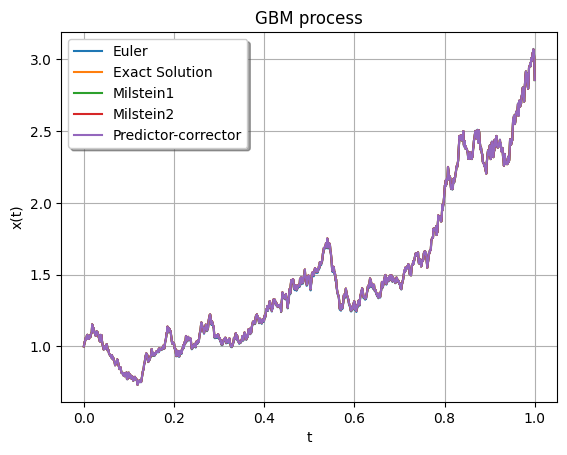

In [4]:
theta1 = 1
theta2 = 1/2
params = [theta1, theta2]

dwt = np.random.normal(0, 1, size = (Nt, Nx)) * np.sqrt(T/Nt)


BSMp = BSMprocess(params, T, Nx, Nt, init_state)
t_data, x_data = BSMp.EulerSolution(dwt)
plt.plot(t_data, x_data, label = 'Euler')

t_data, x_data = BSMp.ExactSolution(dwt)
plt.plot(t_data, x_data, label = 'Exact Solution')

t_data, x_data = BSMp.Milstein1Solution(dwt)
plt.plot(t_data, x_data, label = 'Milstein1')

t_data, x_data = BSMp.Milstein2Solution(dwt)
plt.plot(t_data, x_data, label = 'Milstein2')

t_data, x_data = BSMp.PredictorCorrectorSolution(dwt, 1/2, 1/2)
plt.plot(t_data, x_data, label = 'Predictor-corrector')

plt.title("GBM process")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

Task. Compare the different approximations and the exact solution Brownian motion
for different levels of discretization
$$
N=\{2, 4, 8, 128, 256, 512, 1024, 8192, 16384, 32768\}
$$
being the number of subintervals of $[0,1]$.
As the result provide the table with maximum absolute difference.


Maximum Absolute Differences between Approximations and Exact Solution:
          Euler  Milstein1  Milstein2  PredictorCorrector
N                                                        
2      3.156981   3.379329   0.837547            1.005802
4      3.485661   3.681974   0.573132            0.768145
8      1.138546   1.372889   0.062657            0.139765
128    0.035520   0.015866   0.000517            0.002546
256    0.046240   0.122284   0.002113            0.008598
512    0.023815   0.035149   0.001008            0.003118
1024   0.066410   0.058470   0.000626            0.002318
8192   0.010731   0.000238   0.000007            0.000034
16384  0.012807   0.001346   0.000012            0.000073
32768  0.005641   0.000150   0.000013            0.000003


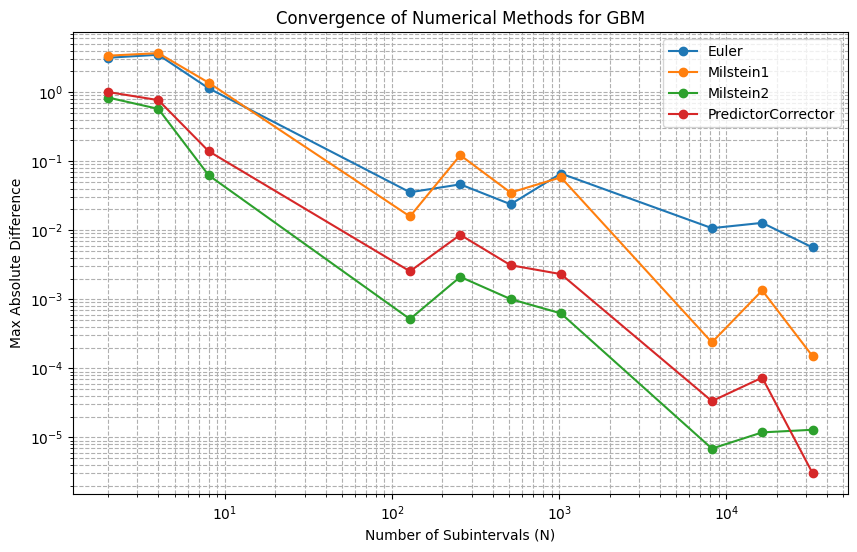

In [ ]:
np.random.seed(123)

T = 1
Nx = 1 
x0 = 1
init_state = x0 * np.ones(Nx)

theta1 = 2
theta2 = 0.5
params = [theta1, theta2]

N_list = [2, 4, 8, 128, 256, 512, 1024, 8192, 16384, 32768]

methods = ['Euler', 'Milstein1', 'Milstein2', 'PredictorCorrector']
results = {method: [] for method in methods}
results['N'] = []

for N in N_list:
    Nt = N
    dt = T / Nt

    dwt = np.random.normal(0, 1, size=(Nt, Nx)) * np.sqrt(dt)
    
    BSMp = BSMprocess(params, T, Nx, Nt, init_state)
    
    t_exact, x_exact = BSMp.ExactSolution(dwt)
    x_exact = x_exact.flatten()
    
    t_euler, x_euler = BSMp.EulerSolution(dwt)
    x_euler = x_euler.flatten()
    max_diff_euler = np.max(np.abs(x_euler - x_exact))
    results['Euler'].append(max_diff_euler)

    t_mil1, x_mil1 = BSMp.Milstein1Solution(dwt)
    x_mil1 = x_mil1.flatten()
    max_diff_mil1 = np.max(np.abs(x_mil1 - x_exact))
    results['Milstein1'].append(max_diff_mil1)
    
    t_mil2, x_mil2 = BSMp.Milstein2Solution(dwt)
    x_mil2 = x_mil2.flatten()
    max_diff_mil2 = np.max(np.abs(x_mil2 - x_exact))
    results['Milstein2'].append(max_diff_mil2)
    
    t_pc, x_pc = BSMp.PredictorCorrectorSolution(dwt, eta=0.5, alpha=0.5)
    x_pc = x_pc.flatten()
    max_diff_pc = np.max(np.abs(x_pc - x_exact))
    results['PredictorCorrector'].append(max_diff_pc)
    
    results['N'].append(N)

df_results = pd.DataFrame(results)
df_results = df_results.set_index('N')

print("Maximum Absolute Differences between Approximations and Exact Solution:")
print(df_results)

plt.figure(figsize=(10,6))
for method in methods:
    plt.plot(df_results.index, df_results[method], marker='o', label=method)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Subintervals (N)')
plt.ylabel('Max Absolute Difference')
plt.title('Convergence of Numerical Methods for GBM')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()


Task. Conduct a study of the influence of the choice of values $\alpha$ and $\eta$ ​​on the accuracy of the  solution and plot a 3D graph where the x-axis is $α$'s values, y-axis is $\eta$'s values, and z-axis are maximum absolute difference between the exact solution and the predictor-corrector approximation.



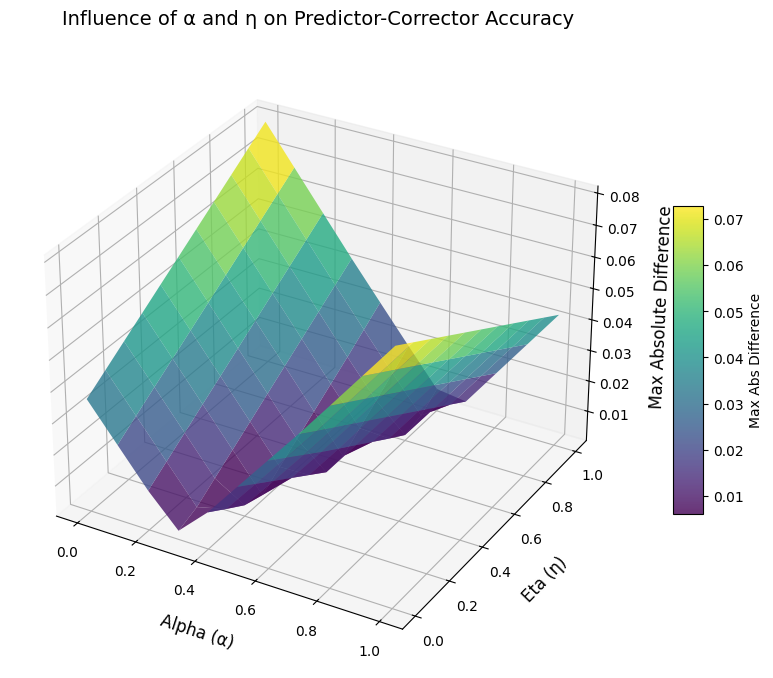

Maximum Absolute Differences for Predictor-Corrector Method:
Alpha       0.0       0.1       0.2       0.3       0.4       0.5       0.6  \
Eta                                                                           
0.0    0.036394  0.040723  0.045054  0.049387  0.053721  0.058057  0.062395   
0.1    0.024692  0.028962  0.033233  0.037507  0.041782  0.046058  0.050337   
0.2    0.012991  0.017202  0.021415  0.025629  0.029845  0.034062  0.038281   
0.3    0.003078  0.005445  0.009598  0.013753  0.017910  0.022068  0.026228   
0.4    0.012104  0.007903  0.003813  0.001880  0.005978  0.010077  0.014178   
0.5    0.023271  0.019027  0.014781  0.010533  0.006284  0.002033  0.002219   
0.6    0.034438  0.030255  0.026071  0.021884  0.017879  0.013898  0.009914   
0.7    0.045605  0.041564  0.037646  0.033725  0.029804  0.025881  0.021956   
0.8    0.057170  0.053311  0.049451  0.045589  0.041726  0.037861  0.033995   
0.9    0.068856  0.065056  0.061254  0.057450  0.053645  0.049839  0.0

In [ ]:
np.random.seed(123)

T = 1
Nx = 1 
x0 = 1
init_state = x0 * np.ones(Nx)

theta1 = 2
theta2 = 0.5
params = [theta1, theta2]
N = 1024
Nt = N
dt = T / Nt

dwt = np.random.normal(0, 1, size=(Nt, Nx)) * np.sqrt(dt)
BSMp = BSMprocess(params, T, Nx, Nt, init_state)
t_exact, x_exact = BSMp.ExactSolution(dwt)
x_exact = x_exact.flatten()

alpha_values = np.linspace(0, 1, 11)  
eta_values = np.linspace(0, 1, 11)   
alpha_list = []
eta_list = []
max_diff_list = []

for alpha in alpha_values:
    for eta in eta_values:
        t_pc, x_pc = BSMp.PredictorCorrectorSolution(dwt, eta=eta, alpha=alpha)
        x_pc = x_pc.flatten()
        
        max_diff = np.max(np.abs(x_pc - x_exact))
        
        alpha_list.append(alpha)
        eta_list.append(eta)
        max_diff_list.append(max_diff)

alpha_array = np.array(alpha_list)
eta_array = np.array(eta_list)
max_diff_array = np.array(max_diff_list)

df_results = pd.DataFrame({
    'Alpha': alpha_array,
    'Eta': eta_array,
    'Max_Abs_Diff': max_diff_array
})


pivot_table = df_results.pivot(index='Eta', columns='Alpha', values='Max_Abs_Diff')

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

alpha_grid, eta_grid = np.meshgrid(alpha_values, eta_values)
max_diff_grid = max_diff_array.reshape(len(eta_values), len(alpha_values))
surf = ax.plot_surface(alpha_grid, eta_grid, max_diff_grid, cmap='viridis', edgecolor='none', alpha=0.8)

ax.set_xlabel('Alpha (α)', fontsize=12, labelpad=10)
ax.set_ylabel('Eta (η)', fontsize=12, labelpad=10)
ax.set_zlabel('Max Absolute Difference', fontsize=12, labelpad=10)
ax.set_title('Influence of α and η on Predictor-Corrector Accuracy', fontsize=14, pad=20)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='Max Abs Difference')
plt.show()
print("Maximum Absolute Differences for Predictor-Corrector Method:")
print(df_results.pivot(index='Eta', columns='Alpha', values='Max_Abs_Diff'))


Task 2.  Repeat the Task 1 for the Cox-Ingersoll-Ross process
$$
dX_t = (\theta_1 - \theta_2X_t)dt + \theta_3 \sqrt{ X_t}dW_t, X_0 = 10, (\theta_1, \theta_2, \theta_3) = (6, 3, 2).
$$

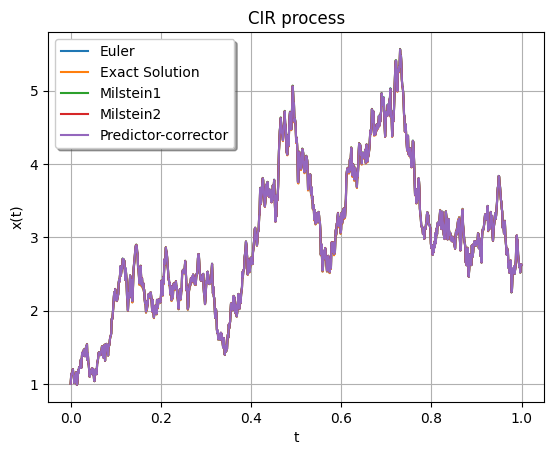

In [7]:
theta1 = 6
theta2 = 3
theta3 = 2
params = [theta1, theta2, theta3]

dwt = np.random.normal(0, 1, size = (Nt, Nx)) * np.sqrt(T/Nt)

CIRp = CIRprocess(params, T, Nx, Nt, init_state)
t_data, x_data = CIRp.EulerSolution(dwt)
plt.plot(t_data, x_data, label = 'Euler')

t_data, x_data = CIRp.ExactSolution(dwt)
plt.plot(t_data, x_data, label = 'Exact Solution')

t_data, x_data = CIRp.Milstein1Solution(dwt)
plt.plot(t_data, x_data, label = 'Milstein1')

t_data, x_data = CIRp.Milstein2Solution(dwt)
plt.plot(t_data, x_data, label = 'Milstein2')

t_data, x_data = CIRp.PredictorCorrectorSolution(dwt, 0.4, 0.6)
plt.plot(t_data, x_data, label = 'Predictor-corrector')

plt.title("CIR process")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

Task. Compare the speed of convergence for four schemes from Task 1 with extract solution on the graph where the x-axis is  log(N) values, y-axis is  X(t). See example in the study aid.

Processing N values: 100%|██████████| 13/13 [00:15<00:00,  1.16s/it]


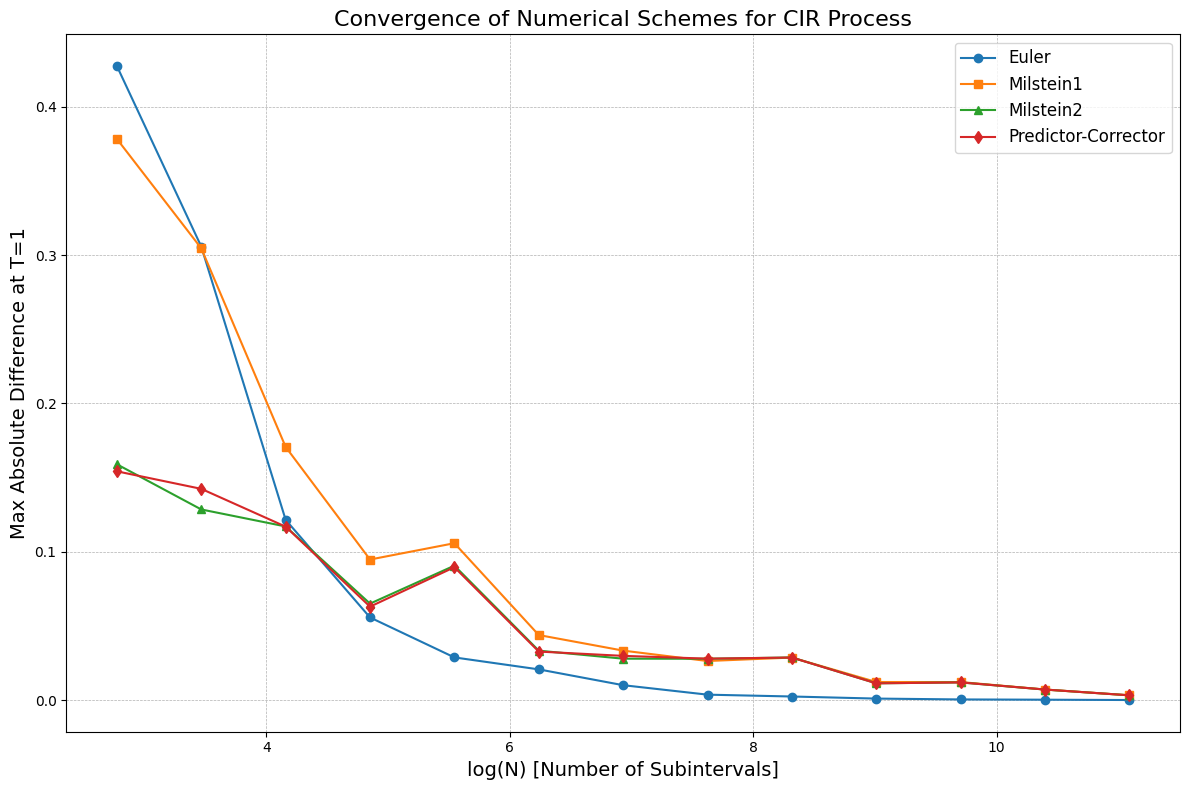

Maximum Absolute Differences for CIR Process:
          Euler  Milstein1  Milstein2  PredictorCorrector
N                                                        
16     0.427349   0.378209   0.158978            0.154235
32     0.305667   0.304497   0.128539            0.142423
64     0.121550   0.170682   0.117081            0.116949
128    0.055765   0.094793   0.065079            0.063046
256    0.028833   0.105795   0.090671            0.089611
512    0.020779   0.043913   0.033378            0.032781
1024   0.010120   0.033414   0.027979            0.029878
2048   0.003739   0.026412   0.027935            0.028000
4096   0.002495   0.028739   0.028803            0.028761
8192   0.001092   0.012264   0.011388            0.011368
16384  0.000517   0.012234   0.011996            0.011991
32768  0.000337   0.007188   0.007169            0.007193
65536  0.000123   0.003317   0.003294            0.003288


In [ ]:
np.random.seed(123)

theta1 = 6
theta2 = 3
theta3 = 2
params = [theta1, theta2, theta3]

x0 = 10
Nx = 1

N_list = [2**i for i in range(4, 17)]

methods = ['Euler', 'Milstein1', 'Milstein2', 'PredictorCorrector']
results = {method: [] for method in methods}
results['N'] = []

for N in tqdm(N_list, desc='Processing N values'):
    Nt = N
    T = 1
    dt = T / Nt
    dwt = np.random.normal(0, 1, size=(Nt, Nx)) * np.sqrt(dt)
    CIRp = CIRprocess(params, T, Nx, Nt, init_state=x0 * np.ones(Nx))
    
    t_exact, x_exact = CIRp.ExactSolution(dwt)
    x_exact = x_exact.flatten()
    
    t_euler, x_euler = CIRp.EulerSolution(dwt)
    x_euler = x_euler.flatten()
    max_diff_euler = np.max(np.abs(x_euler - x_exact))
    results['Euler'].append(max_diff_euler)

    t_mil1, x_mil1 = CIRp.Milstein1Solution(dwt)
    x_mil1 = x_mil1.flatten()
    max_diff_mil1 = np.max(np.abs(x_mil1 - x_exact))
    results['Milstein1'].append(max_diff_mil1)
    
    t_mil2, x_mil2 = CIRp.Milstein2Solution(dwt)
    x_mil2 = x_mil2.flatten()
    max_diff_mil2 = np.max(np.abs(x_mil2 - x_exact))
    results['Milstein2'].append(max_diff_mil2)
    
    t_pc, x_pc = CIRp.PredictorCorrectorSolution(dwt, alpha=0.5, eta=0.5)
    x_pc = x_pc.flatten()
    max_diff_pc = np.max(np.abs(x_pc - x_exact))
    results['PredictorCorrector'].append(max_diff_pc)
    
    results['N'].append(N)

df_results = pd.DataFrame(results)
df_results.set_index('N', inplace=True)

df_results['logN'] = np.log(df_results.index)

plt.figure(figsize=(12, 8))
plt.plot(df_results['logN'], df_results['Euler'], marker='o', label='Euler')
plt.plot(df_results['logN'], df_results['Milstein1'], marker='s', label='Milstein1')
plt.plot(df_results['logN'], df_results['Milstein2'], marker='^', label='Milstein2')
plt.plot(df_results['logN'], df_results['PredictorCorrector'], marker='d', label='Predictor-Corrector')

plt.xlabel('log(N) [Number of Subintervals]', fontsize=14)
plt.ylabel('Max Absolute Difference at T=1', fontsize=14)
plt.title('Convergence of Numerical Schemes for CIR Process', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()

print("Maximum Absolute Differences for CIR Process:")
print(df_results[['Euler', 'Milstein1', 'Milstein2', 'PredictorCorrector']])


Task 3. Generate 100 paths using conditional distribution of
* Ornstein-Uhlenbeck process $θ = (1, 1, 0.5)$,
* Geometric Brownian motion process $θ = (0.3, 0.1)$,
* Cox-Ingersoll-Ross process $θ = (0.4, 0.3, 0.2)$

with $X_0=0.5$.
Plot the random path for each process.

In [9]:
Nx = 100
Nt = 300

T = 1

params_OU = [1, 1, 0.5]
params_BSM = [0.3, 0.1]
params_CIR = [0.4, 0.3, 0.2]

init_state = 0.5 * np.ones(Nx)

OUp = OUprocess(params_OU, T, Nx, Nt, init_state)
BSMp = BSMprocess(params_BSM, T, Nx, Nt, init_state)
CIRp = CIRprocess(params_CIR, T, Nx, Nt, init_state)

t_data, x_data_OU = OUp.PathGenerator()
t_data, x_data_BSM = BSMp.PathGenerator()
t_data, x_data_CIR = CIRp.PathGenerator()

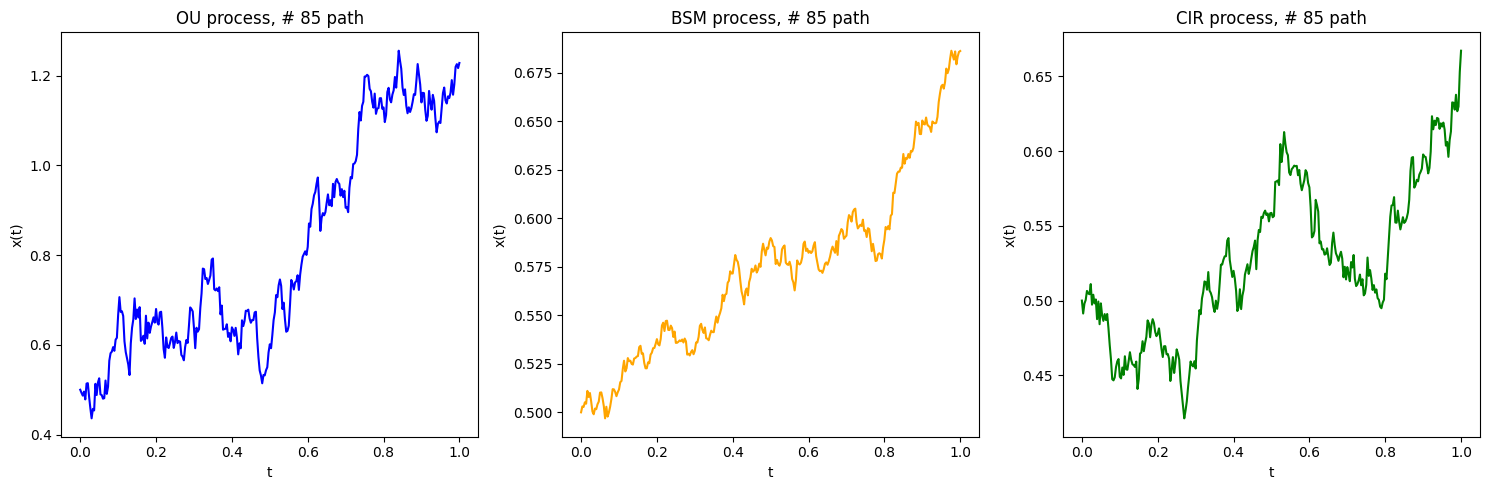

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

n = np.random.randint(0, Nx)

axs[0].plot(t_data, x_data_OU[:,n], color='blue')
axs[0].set_title(f'OU process, # {n} path')
axs[0].set_xlabel('t')
axs[0].set_ylabel('x(t)')

axs[1].plot(t_data, x_data_BSM[:,n], color='orange')
axs[1].set_title(f'BSM process, # {n} path')
axs[1].set_xlabel('t')
axs[1].set_ylabel('x(t)')

axs[2].plot(t_data, x_data_CIR[:,n], color='green')
axs[2].set_title(f'CIR process, # {n} path')
axs[2].set_xlabel('t')
axs[2].set_ylabel('x(t)')

plt.tight_layout()

plt.show()

Task. Using the class template from Task 1, create class and design the path generator for one from the following processes:

1.   Modified CIR model;
2.   Chan-Karolyi-Longstaff-Sanders family of models;
1.   Nonlinear mean reversion Ait-Sahalia model;
2.   Jacobi diffusion process;
1.   Ahn and Gao (inverse of Feller’s square root) model;
2.   Radial Ornstein-Uhlenbeck process.

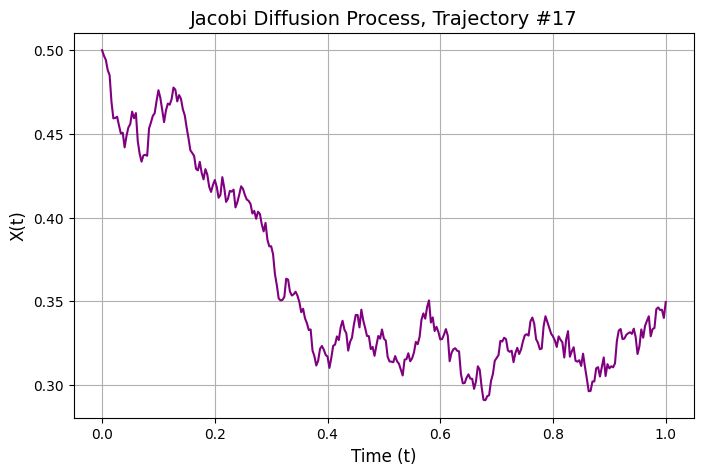

In [ ]:

class JacobiProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        """
        Initialize the Jacobi Diffusion Process.

        Parameters:
        - params: list or tuple containing [kappa, theta, sigma]
        - T: Total time
        - Nx: Number of trajectories
        - Nt: Number of time steps
        - init_state: Initial state vector (optional)
        """
        super().__init__(params, T, Nx, Nt, init_state)
        
        self.kappa = self.params[0]
        self.theta = self.params[1]
        self.sigma = self.params[2]
        
        self.bxt = lambda x: self.kappa * (self.theta - x)
        self.sigmaxt = lambda x: self.sigma * np.sqrt(x * (1 - x))
        
        self.bxt_x = lambda x: -self.kappa
        
        self.sigmaxt_x = lambda x: self.sigma * (1 - 2 * x) / (2 * np.sqrt(x * (1 - x) + 1e-10))

        self.sigmaxt_xx = lambda x: self.sigma * (
            -2 / (2 * np.sqrt(x * (1 - x) + 1e-10)) -
            (1 - 2 * x)**2 / (4 * (x * (1 - x) + 1e-10)**1.5)
        )
    
    def DefaultInitState(self):
        """
        Default initial state for Jacobi Process.
        Typically, set to the long-term mean theta.
        """
        return self.theta * np.ones(self.Nx)
    
    def StationaryState(self):
        """
        Stationary distribution of the Jacobi Process is the Beta distribution.
        Parameters are derived from the SDE coefficients.
        
        For the Jacobi diffusion:
        - alpha = 2 * kappa * theta / sigma^2
        - beta = 2 * kappa * (1 - theta) / sigma^2
        """
        alpha = 2 * self.kappa * self.theta / self.sigma**2
        beta_param = 2 * self.kappa * (1 - self.theta) / self.sigma**2
        return beta.rvs(alpha, beta_param, size=self.Nx)
    
    def SampleFromDensity(self, x0, t, t0):
        """
        Sample the next state from the conditional distribution.
        For the Jacobi process, the transition density is not analytically tractable,
        so we use the Euler-Maruyama method or other numerical schemes.
        Here, we'll implement the Euler-Maruyama step.
        """
        dt = t - t0
        dW = np.random.normal(0, np.sqrt(dt), size=self.Nx)
        x_next = x0 + self.bxt(x0) * dt + self.sigmaxt(x0) * dW
        # Reflecting boundaries to keep x in [0,1]
        x_next = np.clip(x_next, 1e-6, 1 - 1e-6)
        return x_next
    
    def ExactSolution(self, dwt):
        """
        Since the exact solution of the Jacobi process is not available in closed form,
        we return the numerical solution using a highly accurate method, such as Predictor-Corrector.
        Alternatively, implement an exact simulation if possible.
        """
        return self.PredictorCorrectorSolution(dwt, alpha=0.5, eta=0.5)
    
    def PathGenerator(self):
        """
        Generate paths using the Euler-Maruyama method.
        """
        return super().EulerSolution(np.random.normal(0, 1, size=(self.Nt, self.Nx)) * np.sqrt(self.T / self.Nt))


theta_jacobi = [0.4, 0.3, 0.2]  # [kappa, theta, sigma]
T = 1
Nx = 100  
Nt = 300
init_state_jacobi = 0.5 * np.ones(Nx)

Jacobi_p = JacobiProcess(theta_jacobi, T, Nx, Nt, init_state_jacobi)
t_data, x_data_Jacobi = Jacobi_p.PathGenerator()
fig, ax = plt.subplots(figsize=(8, 5))
n = np.random.randint(0, Nx)

ax.plot(t_data, x_data_Jacobi[:, n], color='purple')
ax.set_title(f'Jacobi Diffusion Process, Trajectory #{n}', fontsize=14)
ax.set_xlabel('Time (t)', fontsize=12)
ax.set_ylabel('X(t)', fontsize=12)
ax.grid(True)
plt.show()


Task 4. For the processes from previous task plot
* cumulative distribution (cdf),
* density function (pdf),      
* calculate the 90\%-quantile.

In [12]:
def ecdf(data):
    x = np.sort(data)
    y = np.arange(len(x))/float(len(x))
    return x, y

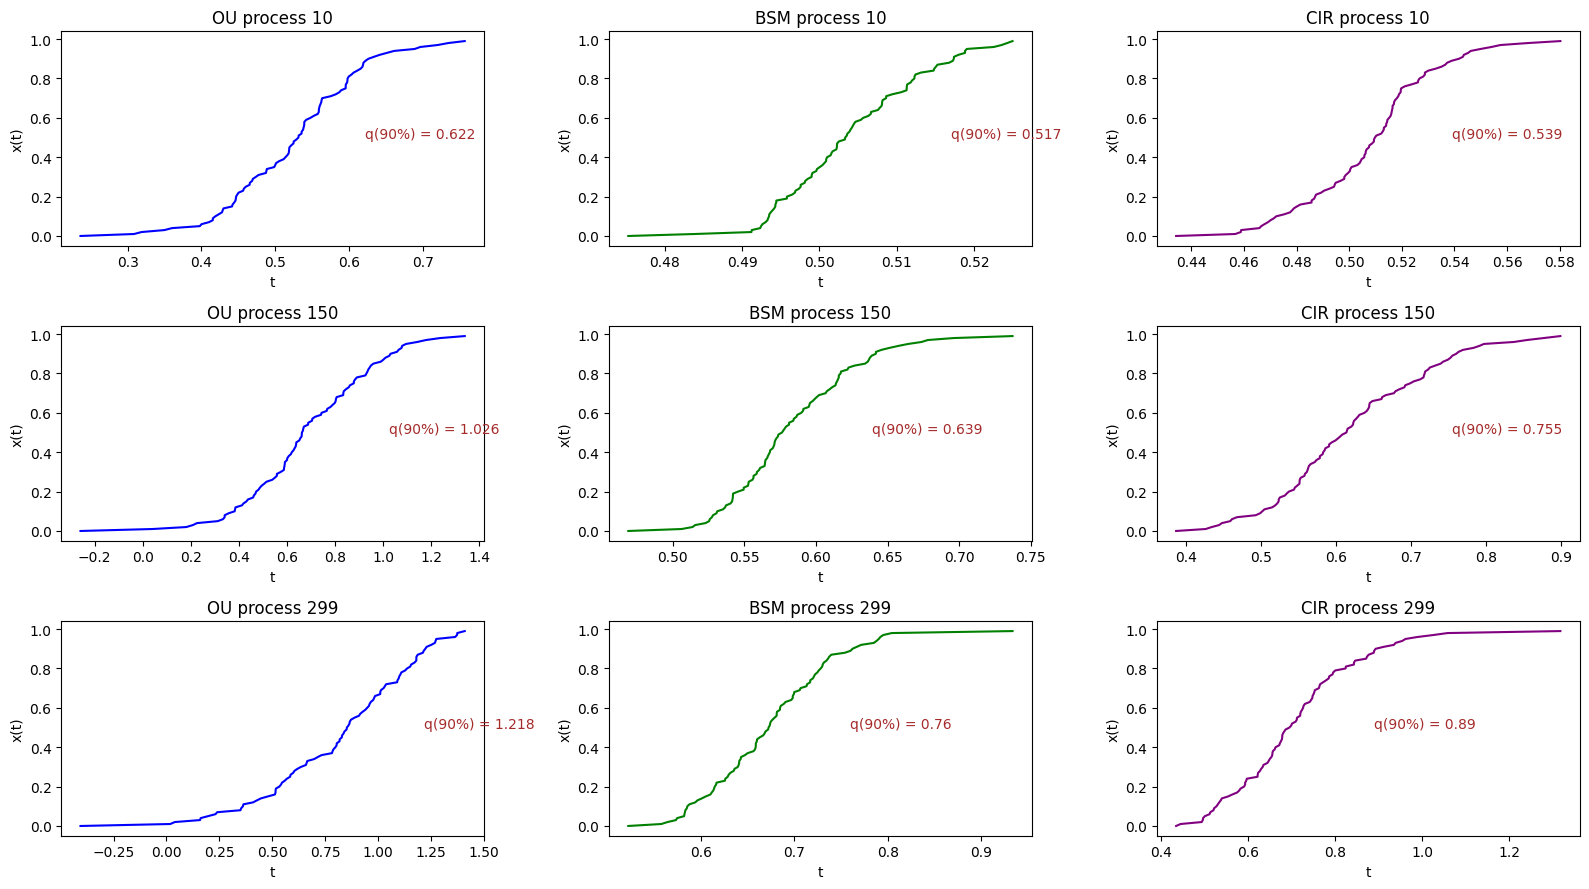

In [ ]:

fig, axs = plt.subplots(3, 3, figsize=(16, 9))

n = 10

axs[0][0].plot(*ecdf(x_data_OU[n]), color='blue')
axs[0][0].set_title(f'OU process {n}')
val = round(np.quantile(x_data_OU[n], 0.9),3)
axs[0][0].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[0][1].plot(*ecdf(x_data_BSM[n]), color='green')
axs[0][1].set_title(f'BSM process {n}')
val = round(np.quantile(x_data_BSM[n], 0.9),3)
axs[0][1].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[0][2].plot(*ecdf(x_data_CIR[n]), color='purple')
axs[0][2].set_title(f'CIR process {n}')
val = round(np.quantile(x_data_CIR[n], 0.9),3)
axs[0][2].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

n = Nt // 2
axs[1][0].plot(*ecdf(x_data_OU[n]), color='blue')
axs[1][0].set_title(f'OU process {n}')
val = round(np.quantile(x_data_OU[n], 0.9),3)
axs[1][0].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[1][1].plot(*ecdf(x_data_BSM[n]), color='green')
axs[1][1].set_title(f'BSM process {n}')
val = round(np.quantile(x_data_BSM[n], 0.9),3)
axs[1][1].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[1][2].plot(*ecdf(x_data_CIR[n]), color='purple')
axs[1][2].set_title(f'CIR process {n}')
val = round(np.quantile(x_data_CIR[n], 0.9),3)
axs[1][2].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

n = Nt - 1
axs[2][0].plot(*ecdf(x_data_OU[n]), color='blue')
axs[2][0].set_title(f'OU process {n}')
val = round(np.quantile(x_data_OU[n], 0.9),3)
axs[2][0].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[2][1].plot(*ecdf(x_data_BSM[n]), color='green')
axs[2][1].set_title(f'BSM process {n}')
val = round(np.quantile(x_data_BSM[n], 0.9),3)
axs[2][1].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

axs[2][2].plot(*ecdf(x_data_CIR[n]), color='purple')
axs[2][2].set_title(f'CIR process {n}')
val = round(np.quantile(x_data_CIR[n], 0.9),3)
axs[2][2].text(val, 0.5, f"q(90%) = {val}", color = 'brown')

for k in range(0, 3):
    for j in range(0, 3):
        #axs[k][j].set_ylim(0, 1)
        #axs[k][j].set_xlim(0, 2)
        axs[k][j].set_xlabel('t')
        axs[k][j].set_ylabel('x(t)')

plt.tight_layout()
plt.show()

Task. Perform the Kolmogorov-Smirnov test for two samples and present your conclusions. Add vertical lines (90\%-quantile) into plots.
Resize the range on the X-axis so that all curves for one process have the same range.    

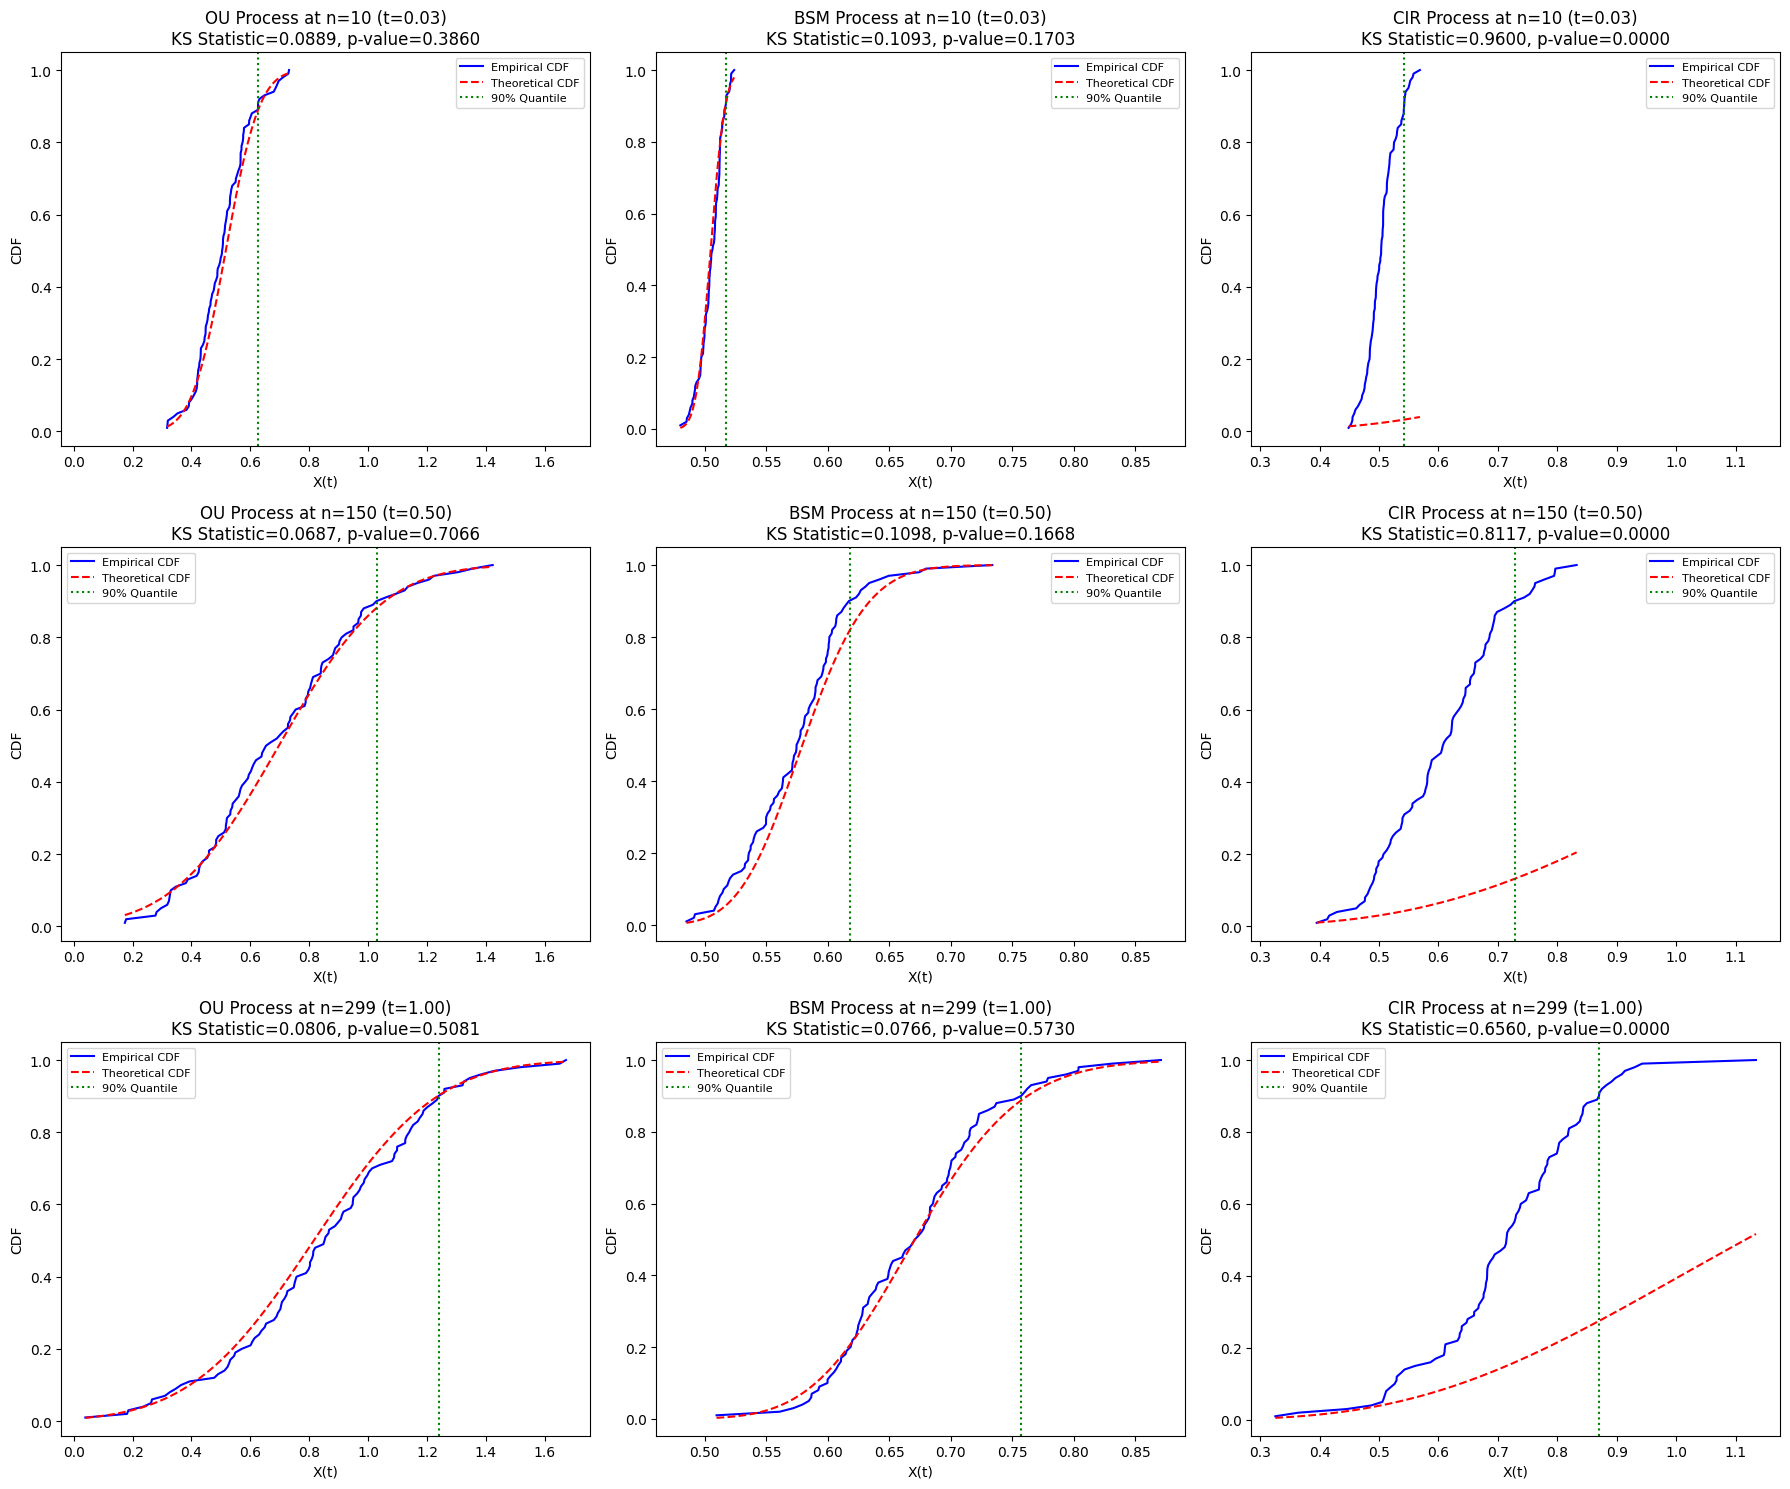

Kolmogorov-Smirnov Test Results:
Process: OU, Time Step: 10 (t=0.03)
  KS Statistic: 0.0889, p-value: 0.3860
  Conclusion: Do not reject the null hypothesis. The sample follows the theoretical distribution.

Process: BSM, Time Step: 10 (t=0.03)
  KS Statistic: 0.1093, p-value: 0.1703
  Conclusion: Do not reject the null hypothesis. The sample follows the theoretical distribution.

Process: CIR, Time Step: 10 (t=0.03)
  KS Statistic: 0.9600, p-value: 0.0000
  Conclusion: Reject the null hypothesis. The sample does not follow the theoretical distribution.

Process: OU, Time Step: 150 (t=0.50)
  KS Statistic: 0.0687, p-value: 0.7066
  Conclusion: Do not reject the null hypothesis. The sample follows the theoretical distribution.

Process: BSM, Time Step: 150 (t=0.50)
  KS Statistic: 0.1098, p-value: 0.1668
  Conclusion: Do not reject the null hypothesis. The sample follows the theoretical distribution.

Process: CIR, Time Step: 150 (t=0.50)
  KS Statistic: 0.8117, p-value: 0.0000
  Conclu

In [ ]:
from scipy.stats import norm, lognorm, ncx2, beta as beta_dist, kstest
from scipy.special import betainc, gamma



def ecdf(data):
    """Compute Empirical Cumulative Distribution Function."""
    x = np.sort(data)
    y = np.arange(1, len(x)+1) / len(x)
    return x, y

n_values = [10, Nt//2, Nt-1]

Nx = 100
Nt = 300
T = 1

params_OU = [1, 1, 0.5]        # [theta1, theta2, sigma]
params_BSM = [0.3, 0.1]        # [theta1, theta2]
params_CIR = [0.4, 0.3, 0.2]   # [theta1, theta2, theta3]

init_state = 0.5 * np.ones(Nx)

OUp = OUprocess(params_OU, T, Nx, Nt, init_state)
BSMp = BSMprocess(params_BSM, T, Nx, Nt, init_state)
CIRp = CIRprocess(params_CIR, T, Nx, Nt, init_state)

t_data, x_data_OU = OUp.PathGenerator()
t_data, x_data_BSM = BSMp.PathGenerator()
t_data, x_data_CIR = CIRp.PathGenerator()

def get_theoretical_cdf(process, t, X0):
    """Return the theoretical CDF function for a given process at time t."""
    if isinstance(process, OUprocess):
        theta1, theta2, sigma = process.params
        mean = theta2 + (X0 - theta2) * np.exp(-theta1 * t)
        variance = (sigma**2) / (2 * theta1) * (1 - np.exp(-2 * theta1 * t))
        return lambda x: norm.cdf(x, loc=mean, scale=np.sqrt(variance))
    
    elif isinstance(process, BSMprocess):
        theta1, theta2 = process.params
        mu = theta1
        sigma = theta2
        mean_log = np.log(X0) + (mu - 0.5 * sigma**2) * t
        std_log = sigma * np.sqrt(t)
        return lambda x: lognorm.cdf(x, s=std_log, scale=np.exp(mean_log))
    
    elif isinstance(process, CIRprocess):
        theta1, theta2, theta3 = process.params
        df = (4 * theta1 * theta2) / (theta3**2)
        nonc = (2 * theta2 * np.exp(-theta2 * t) * X0) / (theta3**2)
        scale = (theta3**2) / (2 * theta2)
        return lambda x: ncx2.cdf(x / scale, df=df, nc=nonc)
    
    else:
        raise ValueError("Process type not recognized for theoretical CDF.")

fig, axs = plt.subplots(3, 3, figsize=(18, 15))

processes = ['OU', 'BSM', 'CIR']
process_data = {'OU': x_data_OU, 'BSM': x_data_BSM, 'CIR': x_data_CIR}
process_instances = {'OU': OUp, 'BSM': BSMp, 'CIR': CIRp}

x_limits = {'OU': [np.inf, -np.inf], 'BSM': [np.inf, -np.inf], 'CIR': [np.inf, -np.inf]}

for proc in processes:
    for n in n_values:
        data = process_data[proc][n, :]
        current_min = data.min()
        current_max = data.max()
        if current_min < x_limits[proc][0]:
            x_limits[proc][0] = current_min
        if current_max > x_limits[proc][1]:
            x_limits[proc][1] = current_max

buffer = 0.05

for row, n in enumerate(n_values):
    for col, proc in enumerate(processes):
        data = process_data[proc][n, :]
        instance = process_instances[proc]
        t = t_data[n]
        X0 = init_state[0]
        
        theo_cdf = get_theoretical_cdf(instance, t, X0)
        
        if proc == 'CIR':
            ks_stat, p_value = kstest(data, theo_cdf)
        else:
            ks_stat, p_value = kstest(data, theo_cdf)
        
        ecdf_x, ecdf_y = ecdf(data)
        
        theo_x = np.linspace(data.min(), data.max(), 1000)
        theo_y = theo_cdf(theo_x)
        
        q_90 = np.quantile(data, 0.9)
        
        axs[row, col].plot(ecdf_x, ecdf_y, label='Empirical CDF', color='blue')
        axs[row, col].plot(theo_x, theo_y, label='Theoretical CDF', color='red', linestyle='--')
        axs[row, col].axvline(q_90, color='green', linestyle=':', label='90% Quantile')
        axs[row, col].set_title(f'{proc} Process at n={n} (t={t:.2f})\nKS Statistic={ks_stat:.4f}, p-value={p_value:.4f}', fontsize=12)
        axs[row, col].set_xlabel('X(t)', fontsize=10)
        axs[row, col].set_ylabel('CDF', fontsize=10)
        axs[row, col].set_xlim(x_limits[proc][0] - buffer * abs(x_limits[proc][1] - x_limits[proc][0]),
                               x_limits[proc][1] + buffer * abs(x_limits[proc][1] - x_limits[proc][0]))
        axs[row, col].legend(fontsize=8)
        
plt.tight_layout()
plt.show()

print("Kolmogorov-Smirnov Test Results:")
for row, n in enumerate(n_values):
    for col, proc in enumerate(processes):
        data = process_data[proc][n, :]
        instance = process_instances[proc]
        t = t_data[n]
        X0 = init_state[0]
        theo_cdf = get_theoretical_cdf(instance, t, X0)
        
        if proc == 'CIR':
            ks_stat, p_value = kstest(data, theo_cdf)
        else:
            ks_stat, p_value = kstest(data, theo_cdf)
        
        print(f'Process: {proc}, Time Step: {n} (t={t:.2f})')
        print(f'  KS Statistic: {ks_stat:.4f}, p-value: {p_value:.4f}')
        if p_value < 0.05:
            print('  Conclusion: Reject the null hypothesis. The sample does not follow the theoretical distribution.\n')
        else:
            print('  Conclusion: Do not reject the null hypothesis. The sample follows the theoretical distribution.\n')


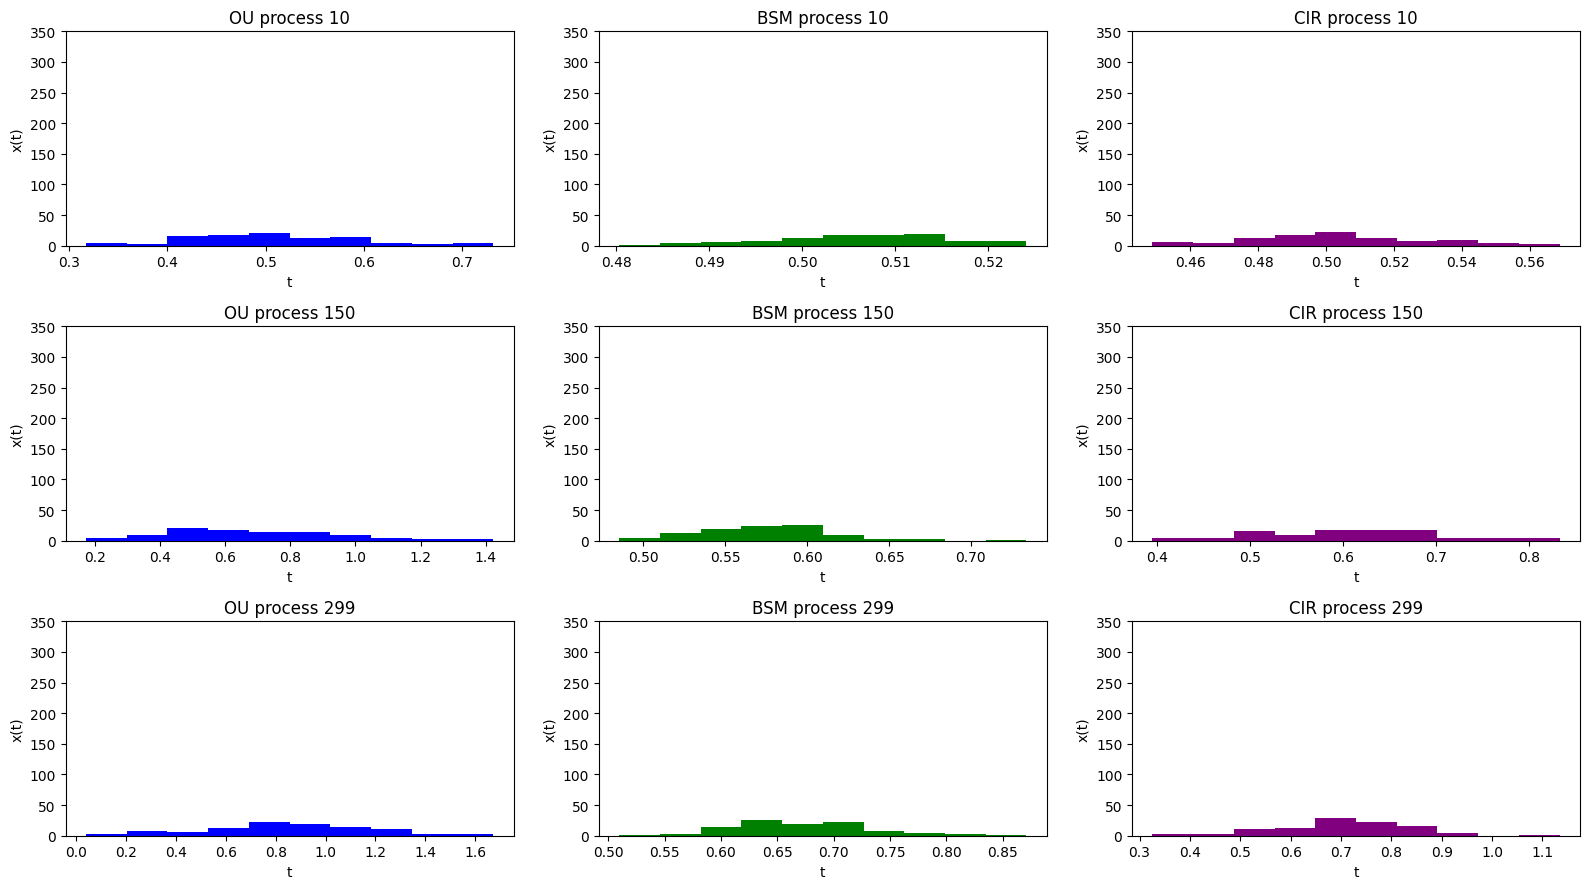

In [ ]:

fig, axs = plt.subplots(3, 3, figsize=(16, 9))

n = 10

axs[0][0].hist(x_data_OU[n], color='blue')
axs[0][0].set_title(f'OU process {n}')

axs[0][1].hist(x_data_BSM[n], color='green')
axs[0][1].set_title(f'BSM process {n}')

axs[0][2].hist(x_data_CIR[n], color='purple')
axs[0][2].set_title(f'CIR process {n}')

n = Nt // 2
axs[1][0].hist(x_data_OU[n], color='blue')
axs[1][0].set_title(f'OU process {n}')

axs[1][1].hist(x_data_BSM[n], color='green')
axs[1][1].set_title(f'BSM process {n}')

axs[1][2].hist(x_data_CIR[n], color='purple')
axs[1][2].set_title(f'CIR process {n}')

n = Nt - 1
axs[2][0].hist(x_data_OU[n], color='blue')
axs[2][0].set_title(f'OU process {n}')

axs[2][1].hist(x_data_BSM[n], color='green')
axs[2][1].set_title(f'BSM process {n}')

axs[2][2].hist(x_data_CIR[n], color='purple')
axs[2][2].set_title(f'CIR process {n}')

for k in range(0, 3):
    for j in range(0, 3):
        axs[k][j].set_ylim(0, 350)
        #axs[k][j].set_xlim(0, 2)
        axs[k][j].set_xlabel('t')
        axs[k][j].set_ylabel('x(t)')

plt.tight_layout()

plt.show()

Task. Perform a normality test on the histograms and present your conclusions.

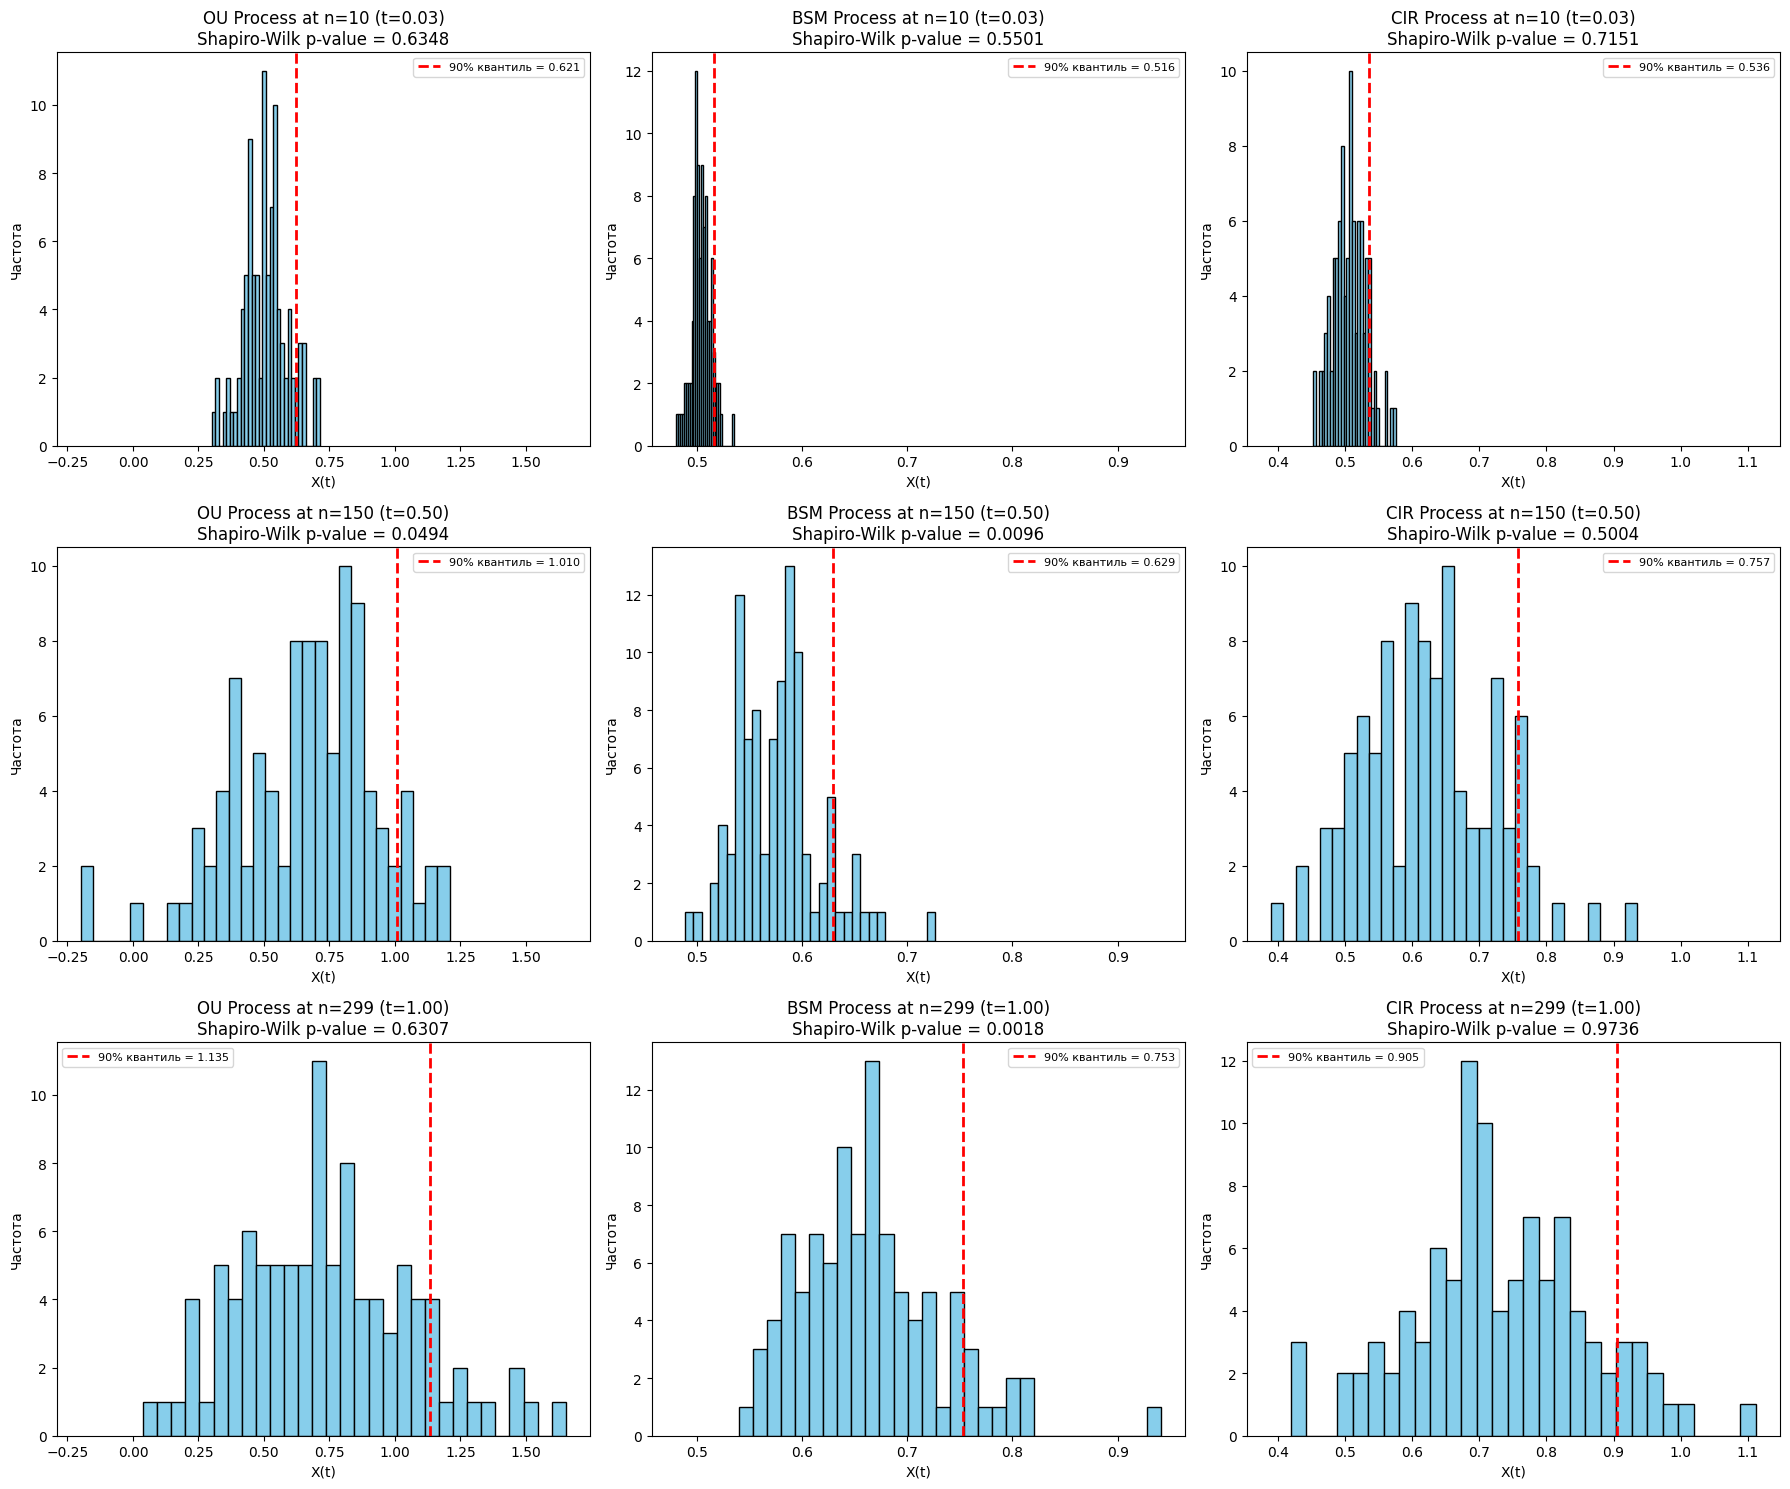


Результаты теста Шапиро-Уилка на нормальность:

Процесс: OU
  Временной шаг: 10 (t=0.03)
    Статистика Шапиро-Уилка: 0.9896
    p-value: 0.6348
    Вывод: Не отвергаем нулевую гипотезу. Данные нормально распределены.

  Временной шаг: 150 (t=0.50)
    Статистика Шапиро-Уилка: 0.9745
    p-value: 0.0494
    Вывод: Отвергаем нулевую гипотезу. Данные не нормально распределены.

  Временной шаг: 299 (t=1.00)
    Статистика Шапиро-Уилка: 0.9896
    p-value: 0.6307
    Вывод: Не отвергаем нулевую гипотезу. Данные нормально распределены.


Процесс: BSM
  Временной шаг: 10 (t=0.03)
    Статистика Шапиро-Уилка: 0.9886
    p-value: 0.5501
    Вывод: Не отвергаем нулевую гипотезу. Данные нормально распределены.

  Временной шаг: 150 (t=0.50)
    Статистика Шапиро-Уилка: 0.9652
    p-value: 0.0096
    Вывод: Отвергаем нулевую гипотезу. Данные не нормально распределены.

  Временной шаг: 299 (t=1.00)
    Статистика Шапиро-Уилка: 0.9550
    p-value: 0.0018
    Вывод: Отвергаем нулевую гипотезу. Да

In [ ]:
from scipy.stats import shapiro

def ecdf(data):
    """Вычислить эмпирическую функцию распределения."""
    x = np.sort(data)
    y = np.arange(1, len(x)+1) / len(x)
    return x, y

n_values = [10, Nt//2, Nt-1]

Nx = 100
Nt = 300
T = 1
params_OU = [1, 1, 0.5]        # [theta1, theta2, sigma]
params_BSM = [0.3, 0.1]        # [theta1, theta2]
params_CIR = [0.4, 0.3, 0.2]   # [theta1, theta2, theta3]

init_state = 0.5 * np.ones(Nx)

OUp = OUprocess(params_OU, T, Nx, Nt, init_state)
BSMp = BSMprocess(params_BSM, T, Nx, Nt, init_state)
CIRp = CIRprocess(params_CIR, T, Nx, Nt, init_state)

t_data, x_data_OU = OUp.PathGenerator()
t_data, x_data_BSM = BSMp.PathGenerator()
t_data, x_data_CIR = CIRp.PathGenerator()

def get_theoretical_cdf(process, t, X0):
    """Вернуть теоретическую функцию CDF для данного процесса в момент времени t."""
    if isinstance(process, OUprocess):
        theta1, theta2, sigma = process.params
        mean = theta2 + (X0 - theta2) * np.exp(-theta1 * t)
        variance = (sigma**2) / (2 * theta1) * (1 - np.exp(-2 * theta1 * t))
        return lambda x: norm.cdf(x, loc=mean, scale=np.sqrt(variance))
    
    elif isinstance(process, BSMprocess):
        theta1, theta2 = process.params
        mu = theta1
        sigma = theta2
        mean_log = np.log(X0) + (mu - 0.5 * sigma**2) * t
        std_log = sigma * np.sqrt(t)
        return lambda x: lognorm.cdf(x, s=std_log, scale=np.exp(mean_log))
    
    elif isinstance(process, CIRprocess):
        theta1, theta2, theta3 = process.params
        df = (4 * theta1 * theta2) / (theta3**2)
        nonc = (2 * theta2 * np.exp(-theta2 * t) * X0) / (theta3**2)
        scale = (theta3**2) / (2 * theta2)
        return lambda x: ncx2.cdf(x / scale, df=df, nc=nonc)
    
    else:
        raise ValueError("Process type not recognized for theoretical CDF.")

fig_hist, axs_hist = plt.subplots(3, 3, figsize=(18, 15))

processes = ['OU', 'BSM', 'CIR']
process_data = {'OU': x_data_OU, 'BSM': x_data_BSM, 'CIR': x_data_CIR}
process_instances = {'OU': OUp, 'BSM': BSMp, 'CIR': CIRp}

x_limits_hist = {'OU': [np.inf, -np.inf], 'BSM': [np.inf, -np.inf], 'CIR': [np.inf, -np.inf]}

for proc in processes:
    for n in n_values:
        data = process_data[proc][n, :]
        current_min = data.min()
        current_max = data.max()
        if current_min < x_limits_hist[proc][0]:
            x_limits_hist[proc][0] = current_min
        if current_max > x_limits_hist[proc][1]:
            x_limits_hist[proc][1] = current_max

buffer = 0.05

test_results = {proc: {} for proc in processes}
for row, n in enumerate(n_values):
    for col, proc in enumerate(processes):
        data = process_data[proc][n, :]
        instance = process_instances[proc]
        t = t_data[n]
        X0 = init_state[0]
        shapiro_stat, shapiro_p = shapiro(data)
        q_90 = np.quantile(data, 0.9)
        axs_hist[row, col].hist(data, bins=30, color='skyblue', edgecolor='black')
        
        
        axs_hist[row, col].axvline(q_90, color='red', linestyle='dashed', linewidth=2, label=f'90% квантиль = {q_90:.3f}')
        axs_hist[row, col].set_title(f'{proc} Process at n={n} (t={t:.2f})\nShapiro-Wilk p-value = {shapiro_p:.4f}', fontsize=12)
        axs_hist[row, col].set_xlabel('X(t)', fontsize=10)
        axs_hist[row, col].set_ylabel('Частота', fontsize=10)
        axs_hist[row, col].legend(fontsize=8)
        
        
        axs_hist[row, col].set_xlim(x_limits_hist[proc][0] - buffer * abs(x_limits_hist[proc][1] - x_limits_hist[proc][0]),
                                    x_limits_hist[proc][1] + buffer * abs(x_limits_hist[proc][1] - x_limits_hist[proc][0]))
        
        test_results[proc][n] = {'Shapiro_Wilk_stat': shapiro_stat, 'Shapiro_Wilk_p': shapiro_p, 'q90': q_90}

plt.tight_layout()
plt.show()

print("\nРезультаты теста Шапиро-Уилка на нормальность:")
for proc in processes:
    print(f"\nПроцесс: {proc}")
    for n in n_values:
        stat = test_results[proc][n]['Shapiro_Wilk_stat']
        p_val = test_results[proc][n]['Shapiro_Wilk_p']
        q90 = test_results[proc][n]['q90']
        print(f"  Временной шаг: {n} (t={t_data[n]:.2f})")
        print(f"    Статистика Шапиро-Уилка: {stat:.4f}")
        print(f"    p-value: {p_val:.4f}")
        if p_val > 0.05:
            conclusion = "Не отвергаем нулевую гипотезу. Данные нормально распределены."
        else:
            conclusion = "Отвергаем нулевую гипотезу. Данные не нормально распределены."
        print(f"    Вывод: {conclusion}\n")
